# Solar Irradiance: prediction project

The goal for this project is predict solar irradiance using a several regression algrotihms. 

## Background

Irradiance is the amount of light energy from one thing hitting a square meter of another each second. Photons that carry this energy have wavelengths from energetic X-rays and gamma rays to visible light to the infrared and radio. It can be measured for any glowing object, including stars, the Moon, and the overly bright high beams of an oncoming car. Human beings radiate primarily infrared light; an infrared image of a human shows a very active heart and mind!

The solar irradiance is the output of light energy from the entire disk of the Sun, measured at the Earth. It is looking at the Sun as we would a star rather than as a image.

## Dataset

NASA provided the dataset during the [Space Apps 2017's "You are my Sunshine" challenge](https://2017.spaceappschallenge.org/challenges/earth-and-us/you-are-my-sunshine), the dataset contains meteorological data from the HI-SEAS Habitat in **Hawaii**. In particular the dataset includes observations of:

* Solar Irradiance (W/m2)
* Temperature (°F)
* Barometric Pressure (Hg)
* Humidity (%)
* Wind Direction (°)
* Wind Speed (mph)
* Sun Rise/Set Time

In [1]:
# Import necessaru libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

# Importing CSV dataset
irra = pd.read_csv("SolarPrediction.csv")

In [2]:
irra.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


Looks like the date are not sorted. I will sort the data based on 'UNIXTime'

In [3]:
irra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


In [4]:
irra.describe()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
count,3.268600e+04,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,1.478047e+09,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869
std,3.005037e+06,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474
min,1.472724e+09,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000
25%,1.475546e+09,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000
50%,1.478026e+09,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000
75%,1.480480e+09,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000
max,1.483265e+09,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000


There are no missing values. Excluding the object data type & UNIXTime, which are datetime features, data type for each feature are of correct format. I will convert the date features into date times.

**Temperature and wind speed are not using the metric unit system.** I will be converting them into celcius and kilometers per hour (kph) respectively.

In [5]:
# Sort dataset based on 'UNIXTime'
irra = irra.sort_values("UNIXTime", ascending=True)

# Convert fahrenheit to celsius
irra["Temperature"] = irra["Temperature"].apply(lambda x: round((x-32) * (5/9), 1))

# Convert mph to kph
irra["Speed"] = irra["Speed"].apply(lambda x: round(x*1.60934,2))

In [6]:
# Drop the data and time columns since I plan on converting UNIXTime into datetime data type which captures these two features
irra.drop(["Data", "Time"], inplace=True, axis=1)

# Converted UNIXTime to datetime
irra["UNIXTime"] = pd.to_datetime(irra["UNIXTime"], unit='s')

# Place UNIXTime as index
irra.set_index("UNIXTime", inplace=True)

# Setting the timezone to UTC and then converting to HST(Hawaii–Aleutian Standard Time)
irra.index = irra.index.tz_localize('UTC').tz_convert('HST')

If you think about it, solar irradiation could be impacted by many things such as but not limited to; month of the year and seasons (days in the year). I will now do some more feature engineeering to explore these possiblities. 

In [7]:
# Created new 'Month' feature to dataset
irra['Month'] = irra.index.strftime('%m').astype(int)

# Created new 'Day' feature to dataset 
irra['Day'] = irra.index.strftime('%j').astype(int)

# Created new 'Hour' feature to dataset
irra['Hour'] = irra.index.hour

In [8]:
irra

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour
UNIXTime,,,,,,,,,,,
2016-09-01 00:00:08-10:00,2.58,10.6,30.43,103,77.27,18.11,06:07:00,18:38:00,9,245,0
2016-09-01 00:05:10-10:00,2.83,10.6,30.43,103,153.44,14.48,06:07:00,18:38:00,9,245,0
2016-09-01 00:20:06-10:00,2.16,10.6,30.43,103,142.04,12.67,06:07:00,18:38:00,9,245,0
2016-09-01 00:25:05-10:00,2.21,10.6,30.43,103,144.12,28.97,06:07:00,18:38:00,9,245,0
2016-09-01 00:30:09-10:00,2.25,10.6,30.43,103,67.42,18.11,06:07:00,18:38:00,9,245,0
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 23:35:02-10:00,1.22,5.0,30.34,83,238.94,10.86,06:57:00,17:54:00,12,366,23
2016-12-31 23:40:01-10:00,1.21,5.0,30.34,82,236.79,9.04,06:57:00,17:54:00,12,366,23
2016-12-31 23:45:04-10:00,1.21,5.6,30.34,81,218.28,12.67,06:57:00,17:54:00,12,366,23


In [9]:
irra.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32686 entries, 2016-09-01 00:00:08-10:00 to 2016-12-31 23:55:01-10:00
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Radiation               32686 non-null  float64
 1   Temperature             32686 non-null  float64
 2   Pressure                32686 non-null  float64
 3   Humidity                32686 non-null  int64  
 4   WindDirection(Degrees)  32686 non-null  float64
 5   Speed                   32686 non-null  float64
 6   TimeSunRise             32686 non-null  object 
 7   TimeSunSet              32686 non-null  object 
 8   Month                   32686 non-null  int64  
 9   Day                     32686 non-null  int64  
 10  Hour                    32686 non-null  int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 3.0+ MB


## EDA

[Text(0.5, 1, 'Feature Correlation')]

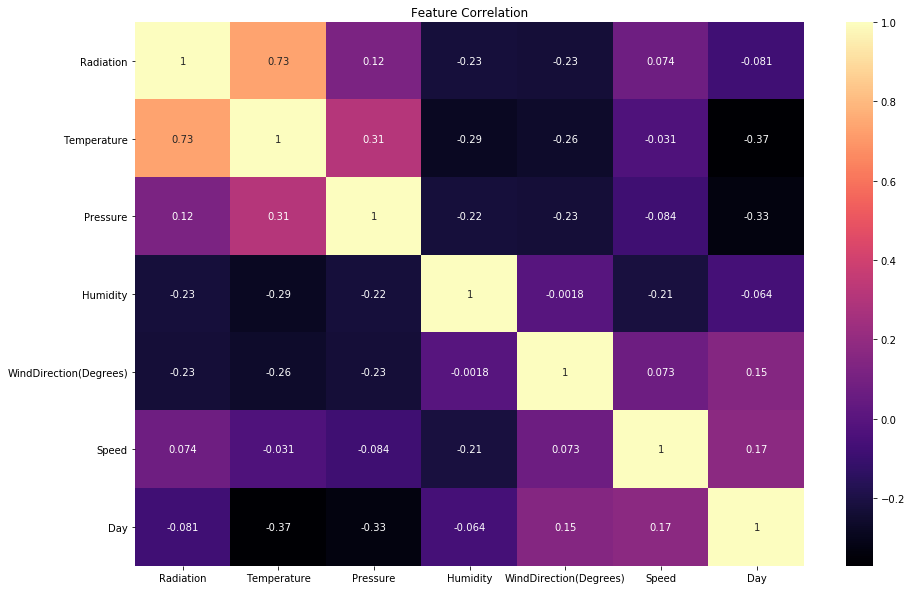

In [428]:
# Setting plot size
plt.subplots(figsize=(15,10))

# Created correlation heatmap
sns.heatmap(irra.drop(['Month','Hour'],axis=1).corr(), annot=True, cmap='magma').set(title = 'Feature Correlation')

There's one strong positive correlation between temperature and radiation. Other than that, there are no other obvious correlations between radiation and other features. 

In [6]:
# Create new dataset based on groupby of 'Hour' and 'Month' respectively
day_h = irra.groupby('Hour').mean().reset_index()
day_m = irra.groupby('Month').mean().reset_index()

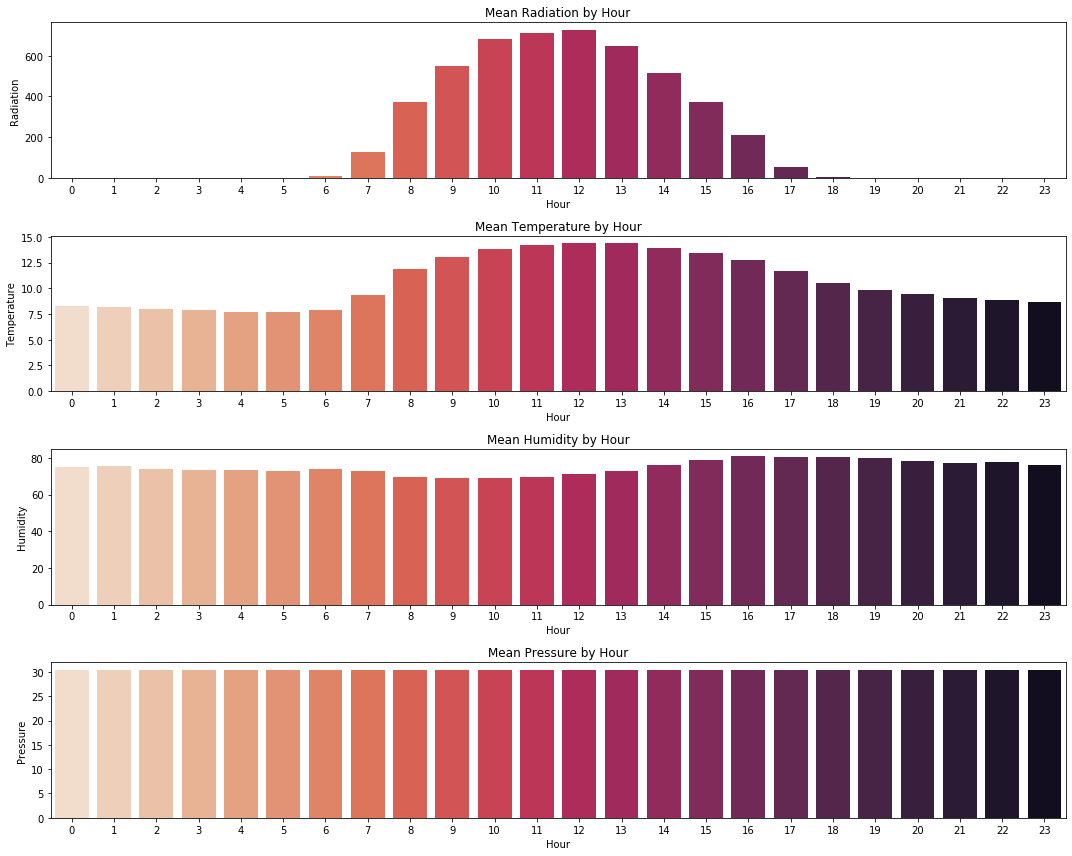

In [7]:
fig, axs = plt.subplots(4, 1, figsize=(15,12))
axs[0].set_title('Mean Radiation by Hour')
axs[1].set_title('Mean Temperature by Hour')
axs[2].set_title('Mean Humidity by Hour')
axs[3].set_title('Mean Pressure by Hour')

sns.barplot(x='Hour', y='Radiation', data=day_h, palette='rocket_r', ax=axs[0])
sns.barplot(x='Hour', y='Temperature', data=day_h, palette='rocket_r', ax=axs[1])
sns.barplot(x='Hour', y='Humidity', data=day_h, palette='rocket_r', ax=axs[2])
sns.barplot(x='Hour', y='Pressure', data=day_h, palette='rocket_r', ax=axs[3])

plt.tight_layout()

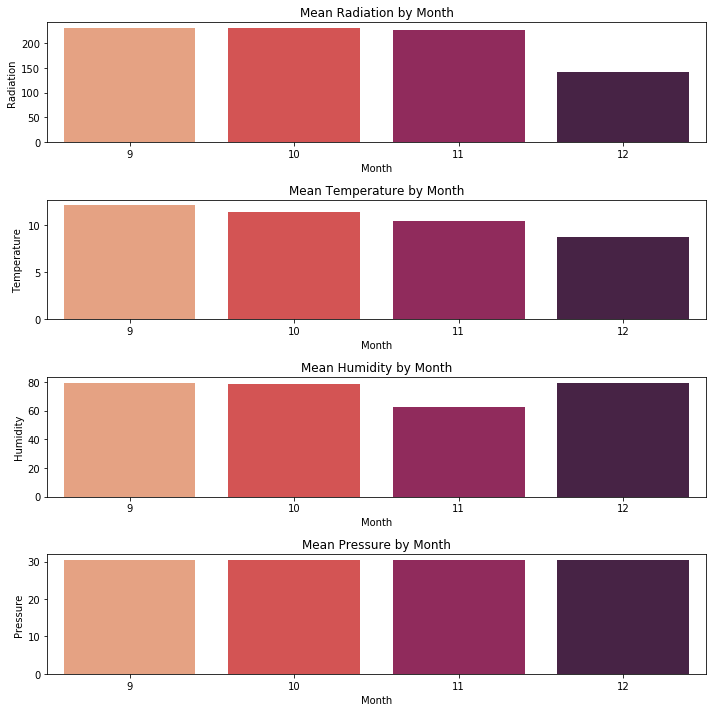

In [392]:
fig, axs = plt.subplots(4, 1, figsize=(10,10))
axs[0].set_title('Mean Radiation by Month')
axs[1].set_title('Mean Temperature by Month')
axs[2].set_title('Mean Humidity by Month')
axs[3].set_title('Mean Pressure by Month')

sns.barplot(x='Month', y='Radiation', data=day_m, palette='rocket_r', ax=axs[0])
sns.barplot(x='Month', y='Temperature', data=day_m, palette='rocket_r', ax=axs[1])
sns.barplot(x='Month', y='Humidity', data=day_m, palette='rocket_r', ax=axs[2])
sns.barplot(x='Month', y='Pressure', data=day_m, palette='rocket_r', ax=axs[3])

plt.tight_layout()

* These plots further proves the strong correlation between temperature and solar irradiance. Relationships between solar irradiance and pressure/humidity aren't as clear but, there seem to be negative correlations between temperature/irradiance/pressure and humidity. 
* Temperature and irradiance peaks around noon which is expected, a point in time where sun is usually directly above the sky. 
* Temperature and irradiance decreases as we head towards winter

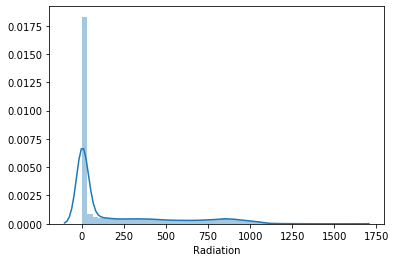

In [432]:
sns.distplot(irra['Radiation'], bins=50)

## Model building (baseline)

The following models used and their respective RM2 are:
* Linear Regression (0.598)
* Support vector ression (0.139)
* Random forest regression (0.868)
* Gradient boosting (0.748)

In [8]:
# Importing necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Importing metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [9]:
# Created train and test sets
X_train, X_test, y_train, y_test = train_test_split(irra[['Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'Day', 'Month']], irra.Radiation, test_size=0.25, random_state=0)

In [290]:
# Creating model instance and performing cross validation
lr = LinearRegression()

crs = cross_val_score(lr, X_train, y_train, cv=5, scoring='r2')
print('Average R2:', crs.mean())

Average R2: 0.5975210823708419


In [291]:
sv = SVR()

crs = cross_val_score(sv, X_train , y_train, cv=5, scoring='r2')
print('Average R2:', crs.mean())

Average R2: 0.1386672136634594


In [11]:
rf = RandomForestRegressor()

crs = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
print('Average R2:', crs.mean())

Average R2: 0.8677345938311838


In [293]:
gb = GradientBoostingRegressor()

crs = cross_val_score(gb, X_train, y_train, cv=5, scoring='r2')
print('Average R2:', crs.mean())

Average R2: 0.7480072479303386


## Model tuning

The best performing model was the RandomForest Regressor. I will be tune the model to see if I can get better performance.

**Scaling won't be necessary**. The nature of RF is such that convergence and numerical precision issues, which can sometimes trip up the algorithms used in logistic and linear regression, as well as neural networks, aren't so important.

In [9]:
# Created simple reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [393]:
# Library imports for hyperparameter tuning
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

rf = RandomForestRegressor(random_state = 1)
param_grid =  {'n_estimators': [100,500], 
                                  'bootstrap': [True,False],
                                  'max_depth': [3,5,10,20,50,75,None],
                                  'max_features': ['auto','sqrt'],
                                  'min_samples_leaf': [1,2,4,10],
                                  'min_samples_split': [2,5,10]}
                                  
rf_par = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter = 50, cv = 5, verbose = 1)
best_rf = rf_par.fit(X_train,y_train)
clf_performance(best_rf,'Random Forest')

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 41.7min finished


Random Forest
Best Score: 0.8660066710787447
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': True}


In [397]:
# Using best parameter, refine hyperparameters even more.
rf = RandomForestRegressor(random_state = 1)
param_grid =  {'n_estimators': [200],
                                  'bootstrap': [True],
                                  'max_depth': [50],
                                  'max_features': ['auto'],
                                  'min_samples_leaf': [2],
                                  'min_samples_split': [2]}
                                  
clf_rf = GridSearchCV(rfr, param_grid = param_grid, cv = 5, verbose = 1, refit = True)
best_clf_rf = clf_rf.fit(X_train, y_train)
clf_performance(best_clf_rf,'Random Forest')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished


Random Forest
Best Score: 0.8667050505256626
Best Parameters: {'bootstrap': True, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


# Model evaluation on testset
Looks like the tune model didn't perform anybetter with the default parameters. I will be using random forest regression with default parameters to predict X_test and compare it to y_test as a final evaluation of my models. **This model has not been exposed to the testset**.

MAE: 54.42707322449329
RMSE: 105.97012926722594
R2_Score: 0.8889029669782617


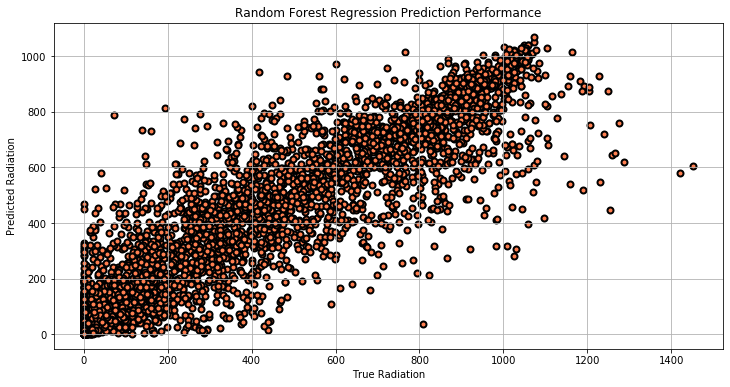

In [10]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# Reporting metrics
print('MAE:', mean_absolute_error(y_test, rf_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, rf_pred)))
print('R2_Score:', r2_score(y_test, rf_pred))

# Created scatter plot of true Vs. predicted radiation
fig = plt.figure(figsize=(12, 6))
plt.scatter(y_test, rf_pred,color='coral', linewidths=2, edgecolors='k')
plt.xlabel('True Radiation') 
plt.ylabel('Predicted Radiation') 
plt.title('Random Forest Regression Prediction Performance') 
plt.grid()

# Model visualising 
I will use the model to predict on the whole X set and compare it to the entire label to visualize the model. 

In [14]:
lab = irra[['Radiation']].copy()
lab['Predicted Radiation'] = rf.predict(irra[['Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'Day', 'Month']])

In [15]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Range1d

output_notebook() 
p = figure(plot_width=800, 
           plot_height=400,
           title="Solar Irradiance Predictions",
           x_axis_label='Date and Time',
           y_axis_label='Solar Irradiance',
           x_axis_type="datetime")
p.x_range = Range1d(lab.index[0], lab.index[600])
p.y_range = Range1d(-100, 1800, bounds=(-100, 1800))
p.line(lab.index, lab['Radiation'], legend_label='Observed Solar Irradiance', line_width=1)
p.line(lab.index, lab['Predicted Radiation'], legend_label='Predicted Solar Irradiance', line_width=1, line_color="red")

show(p, notebook_handle = True)

Loading BokehJS ...

# Conclusion

The features that are the most relevant to solar irradiance was temperature(celsius) and day of the year. The random forest regressor was determined to be the best model which produced a mean R2 of 0.868 in cross validation. When comparing test set against the predictions; R2 score, MAE, and RMSE was 0.888, 54.6, and 106.2 was obtained. 

The model can be further improved by introducing several years of recorded data.

## Model deployment

In [11]:
import joblib

joblib.dump(rf, "final_rf_solar.pkl")

['final_rf_solar.pkl']

In [1]:
import joblib 

rf = joblib.load("final_rf_solar.pkl")

In [2]:
rf.predict([[10.6, 30.43, 103, 77.27, 18.11, 245, 9]])[0]

27.825999999999986